# DataSynthesizer Usage (correlated attribute mode)

> This is a quick demo to use DataSynthesizer in correlated attribute mode.

### Step 1 import packages

In [1]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

import pandas as pd
import os

### Step 2 user-defined parameteres

In [2]:
# paths for the I/O files
current_file_path = os.getcwd()
current_directory = os.path.dirname(current_file_path)
parent_directory  = os.path.dirname(current_directory)
data_directory    = os.path.join(parent_directory, 'data')

input_data        = os.path.join(data_directory, 'CEData.csv')
synthetic_data    = os.path.join(data_directory, 'synthetic_data.csv')
description_file  = os.path.join(data_directory, 'description.json')

In [3]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 20

# specify categorical attributes
categorical_attributes = {'UrbanRural': True, 'Race': True, 'KidsCount': True}

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'': True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset. NOTE: This cannot be less what is being cut in Hornby and Hu, else an error is generated.
num_tuples_to_generate = 1000 # Here 32561 is the same as input dataset, but it can be set to another number.

In [ ]:
### Step 3 DataDescriber

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.

In [4]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT LogExpenditure
Adding attribute TotalExpLastQ
Adding attribute LogIncome
Adding attribute TotalIncomeLastYear
Adding attribute Race
Adding attribute KidsCount
Adding attribute UrbanRural
========================== BN constructed ==========================


In [5]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    TotalExpLastQ       has parents ['LogExpenditure'].
    LogIncome           has parents ['TotalExpLastQ', 'LogExpenditure'].
    TotalIncomeLastYear has parents ['LogIncome', 'TotalExpLastQ'].
    Race                has parents ['TotalIncomeLastYear', 'TotalExpLastQ'].
    KidsCount           has parents ['TotalExpLastQ', 'LogExpenditure'].
    UrbanRural          has parents ['TotalIncomeLastYear', 'LogIncome'].


### Step 4 generate synthetic dataset

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [6]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

### Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

#### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [7]:
# Read both datasets using Pandas.
input_df = pd.read_csv(input_data, skipinitialspace=True)
synthetic_df = pd.read_csv(synthetic_data)
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

#### 5.2 compare histograms between input and synthetic datasets.

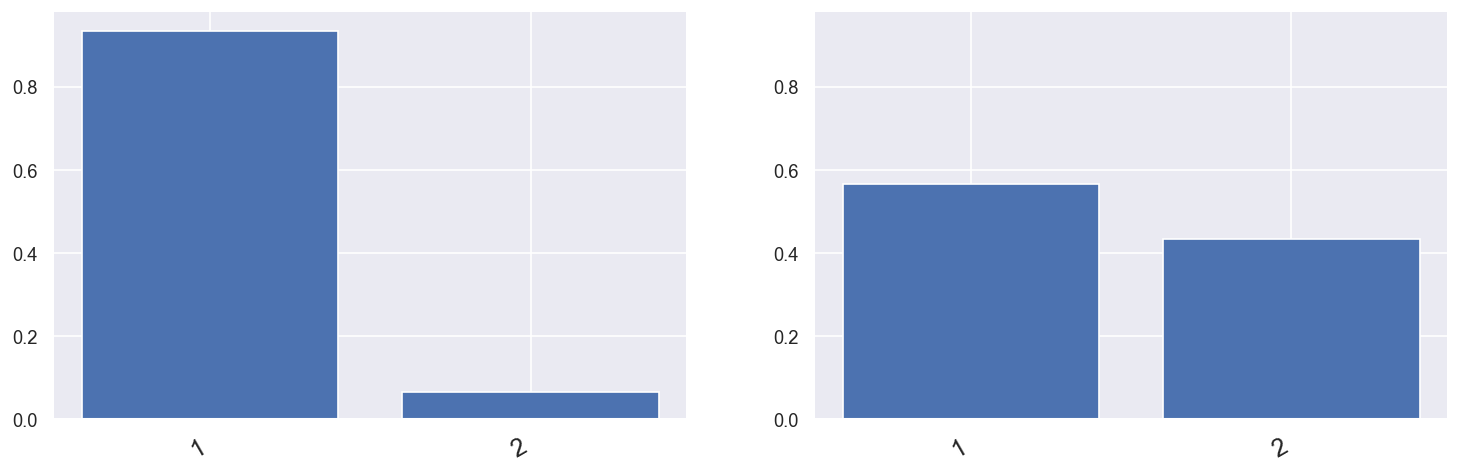

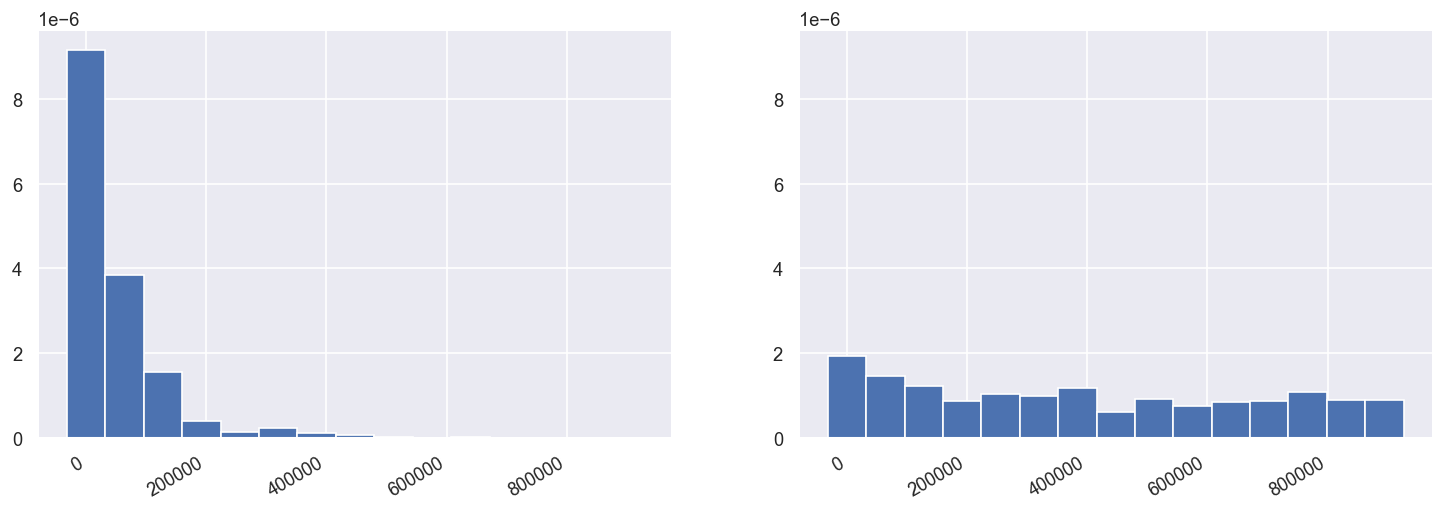

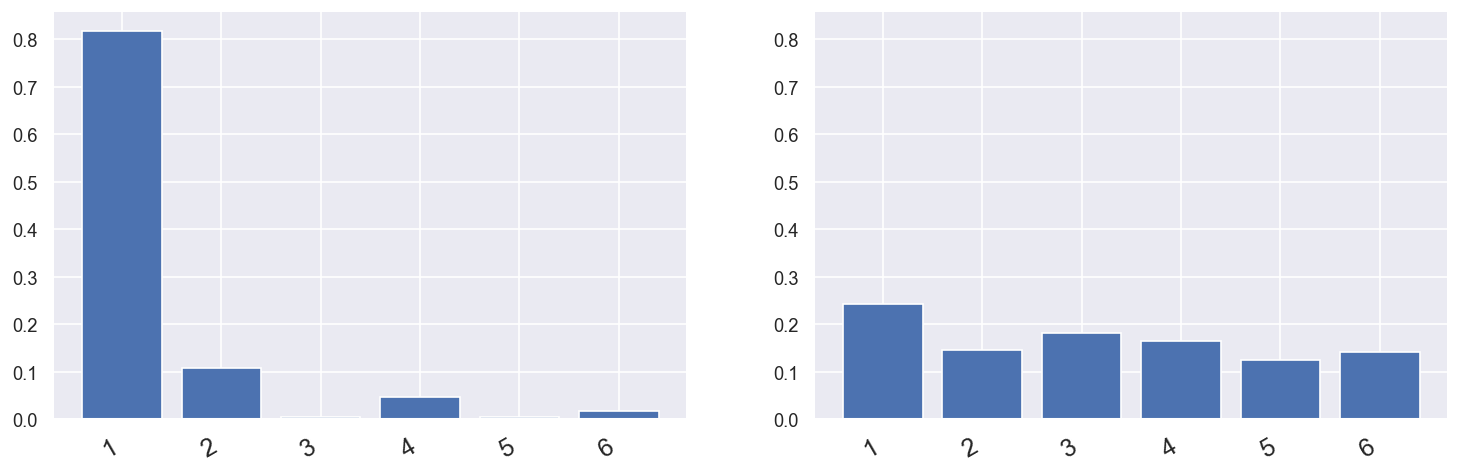

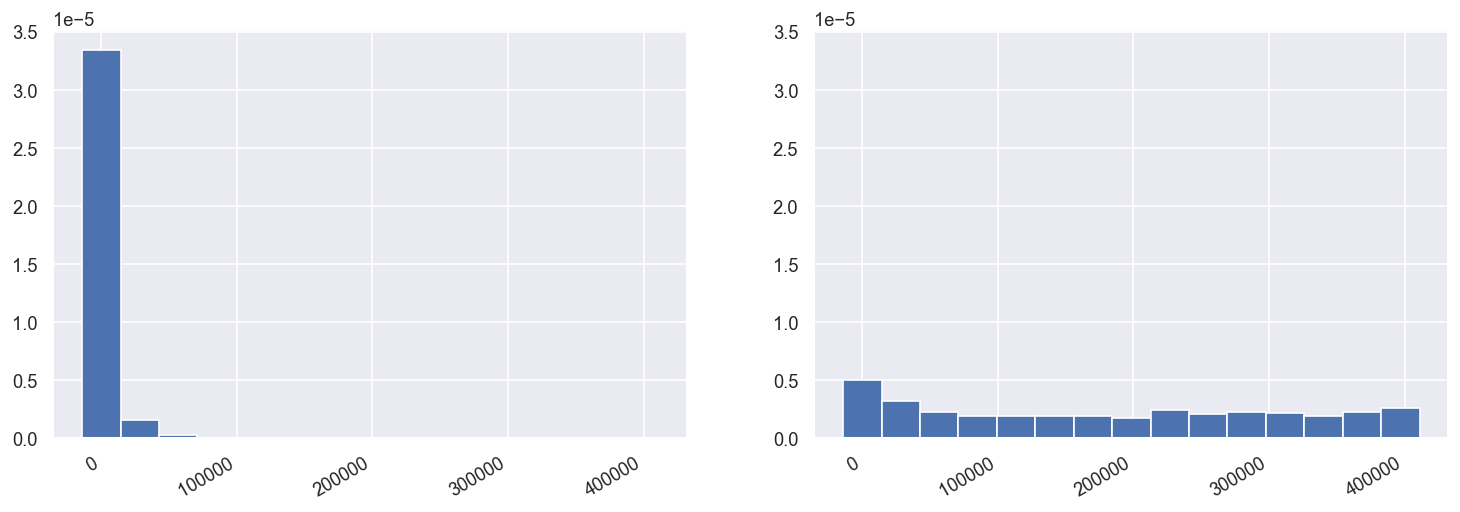

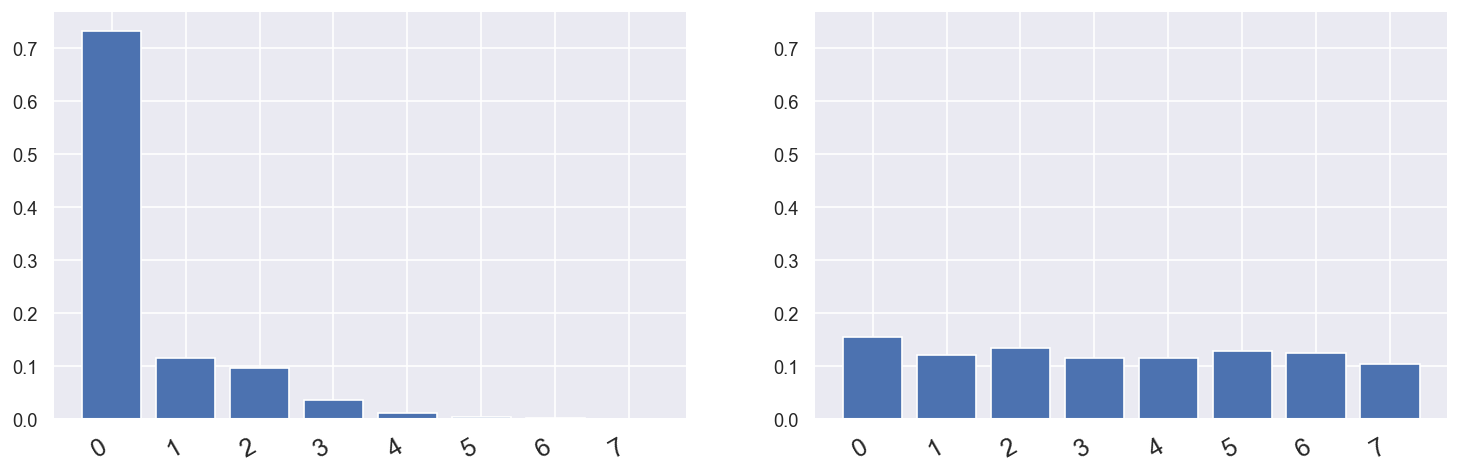

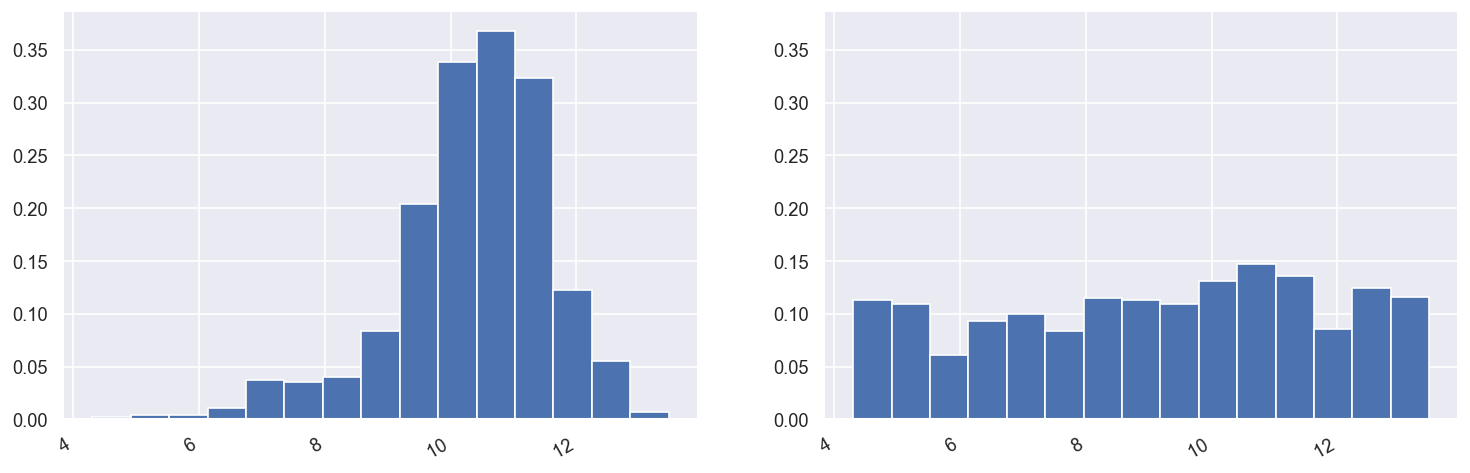

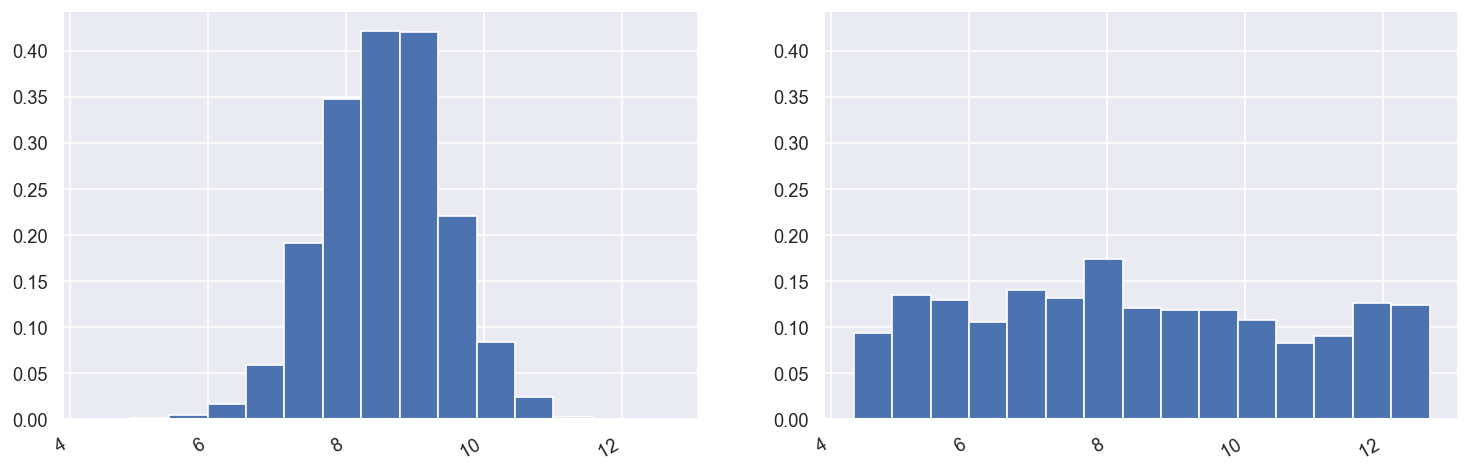

In [8]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

#### 5.3 compare pairwise mutual information

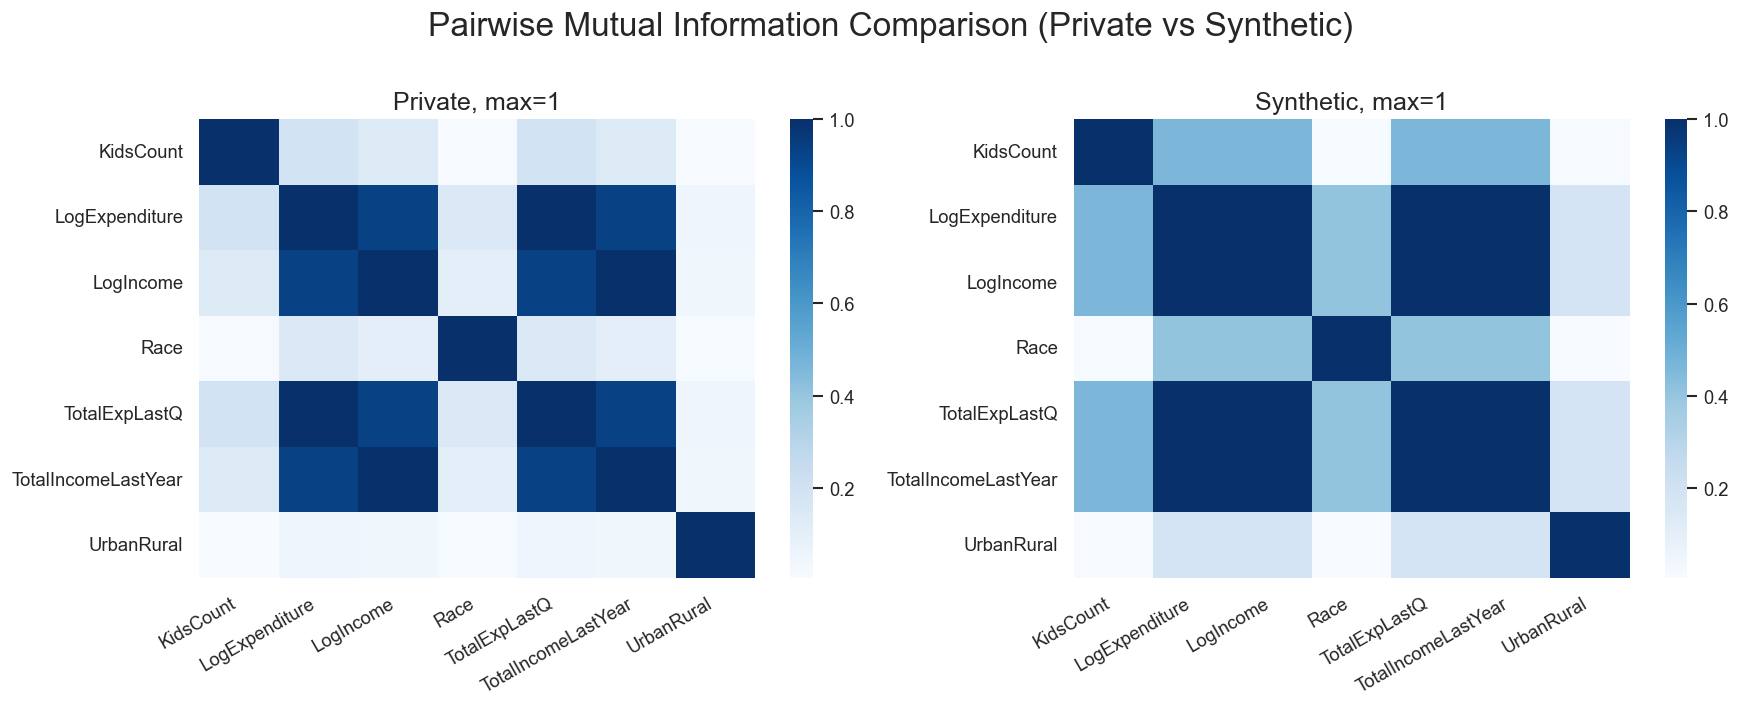

In [9]:
inspector.mutual_information_heatmap()